距離、前距離の重要度が異常に大きいので、この2つを使わずに学習。 


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
data_dir = "F:/TARGET frontier/TXT33/"
data_name = "train"
tail = "fe5"
train_data = pd.read_csv(data_dir+data_name+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})

In [3]:
pd.set_option('display.max_columns', 100)
train_data.head()

,場所,芝・ダ,距離,クラス名,馬場状態,騎手コード,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,調教師コード,前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走騎手コード,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走平均1Fタイム,前走着差タイム,前走単勝オッズ,着差,レースID(旧),複勝オッズ下限,複勝オッズ上限,複勝配当,単勝オッズ
0,2,2,1200,2,3,5212,6,2,3,13,56.0,6.0,5.0,572,8,1105,13,2,1400.0,2,2,660.0,2.0,3,54.0,37.2,33.9,59.53,58.2,59.7,0,11.93,0.2,14.6,0.0,0615581112,1.9,2.7,190.0,5.4
1,2,2,1200,2,3,5339,6,1,3,10,54.0,3.0,3.0,452,8,1002,1,2,1200.0,7,3,5339.0,7.0,3,54.0,34.5,34.6,48.80,46.9,49.7,0,11.52,0.0,2.2,0.0,0615581111,1.3,1.6,130.0,2.8
2,2,2,1200,2,3,5203,3,2,3,9,56.0,5.0,2.0,607,5,1089,3,2,1200.0,2,3,1018.0,8.0,2,56.0,34.5,34.4,50.13,48.0,50.3,0,11.48,0.4,28.6,0.2,0615581106,1.8,2.5,180.0,6.2
3,2,2,1200,2,3,1150,4,1,5,17,55.0,2.0,4.0,91,1,1134,2,2,1200.0,2,2,1150.0,6.0,2,53.0,34.1,34.4,48.17,46.3,49.1,0,11.42,0.0,19.1,0.3,0615581108,1.7,2.5,0.0,6.6
4,2,2,1200,2,3,1004,8,1,3,15,54.0,2.0,4.0,325,4,1030,2,2,1200.0,2,2,1134.0,2.0,5,53.0,33.6,36.4,48.17,46.3,42.3,1,11.67,1.5,8.6,0.3,0615581116,6.3,9.7,0.0,33.9


In [4]:
#test_data
test_data = pd.read_csv(data_dir+"predict"+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})
test_x = test_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","距離","前距離"],axis=1)
test_y = test_data["着差"]

In [5]:
train_x = train_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","距離","前距離"],axis=1)
train_y = train_data["着差"]

In [6]:
#チューニング済みパラメータ(etaのみ手動)
params = {'colsample_bytree': 0.65, 
          'gamma': 0.013439667332810353, 
          'max_depth': 5, 
          'min_child_weight': 2.663317188920419, 
          'subsample': 0.9, 
          'booster': 'gbtree', 
          'objective': 'reg:squarederror', 
          'eta': 0.005, 
          'alpha': 0.0, 
          'lambda': 1.0, 
          'random_state': 71}

In [7]:
#これがないとエラー履くので注意
train_y.fillna(1,inplace=True)
test_y.fillna(1,inplace=True)

In [8]:
scores = []
histories = []
models = []
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=100
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True) #ここまでok
    #print(va_pred[:10])
    #print(va_y[:10])
    score = mean_squared_error(va_y,va_pred)
    score = np.sqrt(mean_squared_error(va_y,va_pred)) #rmse
    scores.append(score)

print(*scores)
print(np.mean(scores))

[0]	train-rmse:1.69065	eval-rmse:1.68561
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.4247	eval-rmse:1.44697
[200]	train-rmse:1.30019	eval-rmse:1.3409
[300]	train-rmse:1.24028	eval-rmse:1.29341
[400]	train-rmse:1.21109	eval-rmse:1.27236
[500]	train-rmse:1.19516	eval-rmse:1.26257
[600]	train-rmse:1.18515	eval-rmse:1.25761
[700]	train-rmse:1.17804	eval-rmse:1.25483
[800]	train-rmse:1.17277	eval-rmse:1.25309
[900]	train-rmse:1.16813	eval-rmse:1.25194
[1000]	train-rmse:1.1644	eval-rmse:1.25109
[1100]	train-rmse:1.16077	eval-rmse:1.25044
[1200]	train-rmse:1.15757	eval-rmse:1.2499
[1300]	train-rmse:1.1546	eval-rmse:1.24947
[1400]	train-rmse:1.15183	eval-rmse:1.24894
[1500]	train-rmse:1.14905	eval-rmse:1.24862
[1600]	train-rmse:1.14635	eval-rmse:1.24823
[1700]	train-rmse:1.14397	eval-rmse:1.24794
[1800]	train-rmse:1.14154	eval-rmse:1.24775
[1900]	train-rmse:1.13911	eval-rmse:1

In [9]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

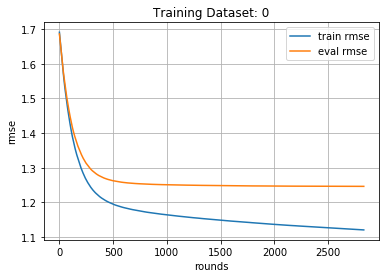

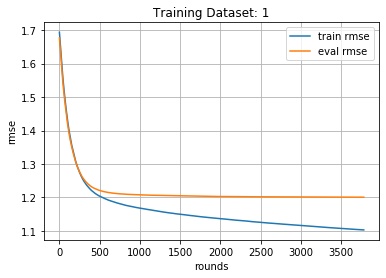

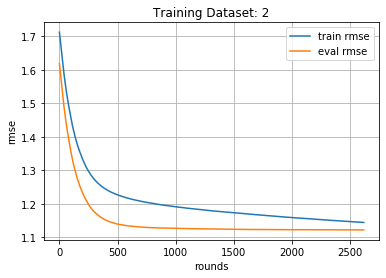

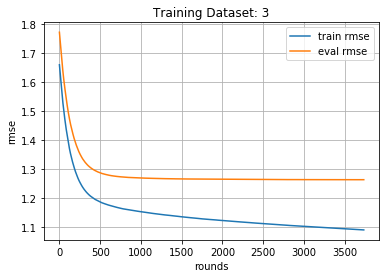

In [10]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [11]:
test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(test_x,label=test_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

In [12]:
y = pd.DataFrame(predict,columns=["y'"])
output = test_data #ここも書き換えること

output = pd.concat([output,y],axis=1)

output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval3.csv",index=False,encoding="shift-jis")

In [13]:
fscore = model.get_score(importance_type="total_gain")
fscore = sorted([(k,v) for k,v in fscore.items()] ,key=lambda tpl: tpl[1], reverse = True)
print(*fscore[:20])

('単勝オッズ', 3542338.2488190606) ('前走着差タイム', 1040292.3896838827) ('斤量', 1010847.5287084011) ('前好走', 642817.3398081647) ('前走平均1Fタイム', 640795.3988235809) ('芝・ダ', 579357.6345212271) ('前走単勝オッズ', 470628.1082326739) ('キャリア', 444025.00838612136) ('クラス名', 353751.26875765686) ('前走上り3F', 333521.7622703058) ('前走Ave-3F', 237186.74389474498) ('間隔', 220945.43113016943) ('前走PCI3', 191916.92631986158) ('前PCI', 161092.18977436205) ('前芝・ダ', 145493.6768117536) ('前走RPCI', 128336.32383573291) ('騎手コード', 128298.44179031262) ('前走騎手コード', 125596.13438903746) ('調教師コード', 104760.07685348086) ('前クラス名', 103151.34607684812)
